In [ ]:
import math
from itertools import product

In [ ]:
sc.uninstall_package('pip')
sc.install_pypi_package("pip==22.2.2")
sc.install_pypi_package("opencv-python")
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib")

In [ ]:
def deg2num(lat_deg, lon_deg, zoom):
    '''
        Convert latitude, longitude to (x,y) tile coordinate at given zoom.
    '''
    lat_rad = math.radians(lat_deg)
    n = 2.0**zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

In [ ]:
def num2deg(xtile, ytile, zoom):
    '''
        Convert (x,y) to latitude, longitude tile coordinate at given zoom.
    '''
    n = 2.0**zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

In [ ]:
def tiles_url(zoom, lat1, lon1, lat2, lon2):
    ''' 
        Convert geographic bounds into a list of tile_url coordinates at given zoom.
    '''
    # convert to geographic bounding box
    minlat, minlon = min(lat1, lat2), min(lon1, lon2)
    maxlat, maxlon = max(lat1, lat2), max(lon1, lon2)

    # convert to tile-space bounding box
    xmin, ymin = deg2num(maxlat, minlon, zoom)
    xmax, ymax = deg2num(minlat, maxlon, zoom)

    # generate a list of tiles_url
    xs, ys = range(xmin, xmax + 1), range(ymin, ymax + 1)
    tiles_url = [(f"s3://elevation-tiles-prod//terrarium/{zoom}/{x}/{y}.png")
                 for (y, x) in product(ys, xs)]

    return tiles_url, (xmax - xmin) + 1, (ymax - ymin) + 1

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
def plot_img(img):
    plt.clf()
    plt.gray()
    plt.imshow(img)


In [ ]:
def plot_map(combo,x_interval, y_interval):
    
#   Połączenie wszystkich obrazków w jedna całość
    columns = [np.concatenate(combo[i*y_interval : (i+1)*y_interval], axis=0) for i in range(x_interval-1)]
    mapp = np.concatenate(columns, axis=1)
    
    plt.clf()
    #plt.gray()
    plt.imshow(mapp)


In [ ]:
def get_height(data):
    #return np.array([list(map(rgb_to_meters, row)) for row in curr_tile])
    (B, G, R) = cv2.split(data)
    out = abs((0.85 * R + 0.15 * G))
    out = np.where(out > 132, out, 0)
    return out

In [ ]:
def create_groups(data):
    rdd = spark.sparkContext.parallelize(data)
    means = rdd.map(lambda x: cv2.mean(x)).sortBy(lambda x: x[0]).collect()

    amount = len(means)
    groups = []
    """
    Groups:
    0 -> 33% of values
    1 -> 33% - 50% of values
    2 -> 50% - 60% of values
    3 -> 60% - 70% of values
    4 -> 70% - 90% of values
    5 -> 90% - 100% of values
    
    """
    
    groups.append((means[-1][0]+1, 252))
    groups.append((means[int(9*amount/10)-1][0], 190))
    groups.append((means[int(7*amount/10)][0], 128))
    groups.append((means[int(3*amount/5)][0], 85))
    groups.append((means[int(amount/2)][0], 45))
    groups.append((means[int(amount/3)][0], 0))
    
    return groups


In [ ]:
def processing(arr, groups):
    for limit, val in groups:
        np.where(arr <= limit, arr, val)
    return arr

In [ ]:
def paint(data, groups):
    rdd = spark.sparkContext.parallelize(data)
    return rdd.map(lambda x: processing(x, groups)).collect()

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

In [ ]:
def to_idx(file):
    out = int(file.split("/")[5])
    return out

def to_idy(file):
    out = file.split("/")[6]
    out = int(out.split(".")[0])
    return out

In [ ]:
def main():
    
    AMERICA = (74, -174, 8, -40)
    TEST = (30, -85, 24, -79)
    
    data, x_interval, y_interval = tiles_url(5, *AMERICA)
    
    
    input_data = spark.read.format("image").load(data)
    input_data2 = input_data.select("image.origin", "image.data")
    
    new_idx = F.udf(to_idx, IntegerType())
    new_idy = F.udf(to_idy, IntegerType())

    input_data2 = input_data2.withColumn("idx", new_idx("origin"))
    input_data2 = input_data2.withColumn("idy", new_idy("origin"))
    input_data2 = input_data2.orderBy(col("idx").asc(), col("idy").asc())
    
    images = input_data2.select("data") 
    
    images = images.rdd.map(lambda img: np.reshape(img, (256,256,3))) #images<dateframe> to images<rdd>
    images = images.map(get_height)
    
          
    # gradient 
    gX = images.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 1, 0))
    gY = images.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 0, 1))

    gx = np.asarray(gX.take(gX.count()))
    gy = np.asarray(gY.take(gY.count()))

    #combined = cv2.addWeighted(gx, 0.5, gy, 0.5, 0)
    combined = np.sqrt(gx**2 + gy**2)


    groups = create_groups(combined)
    painted = paint(combined, groups)
    plot_map(painted, x_interval, y_interval)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

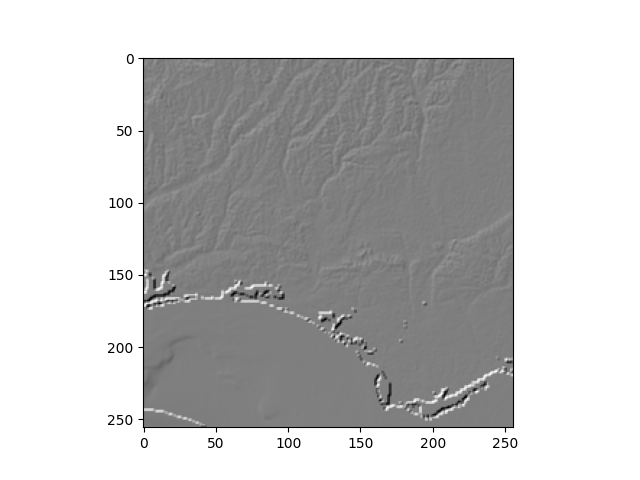

In [17]:
main()
%matplot plt